# Hindcast nitrate summary

For upwelling manuscript, Moore-Maley et al. in prep

***

In [320]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yaml
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm.notebook import tqdm
from glob import glob
from salishsea_tools.places import PLACES

%matplotlib inline
plt.rcParams['font.size'] = 11

In [2]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, _, _ = yaml.safe_load_all(f)
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/local/'

In [380]:
y, x = [slice(*subdomains['NO3'][slice(*pair)]) for pair in [(2, 4), (0, 2)]]
tmask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').tmask[0, 0, y, x]

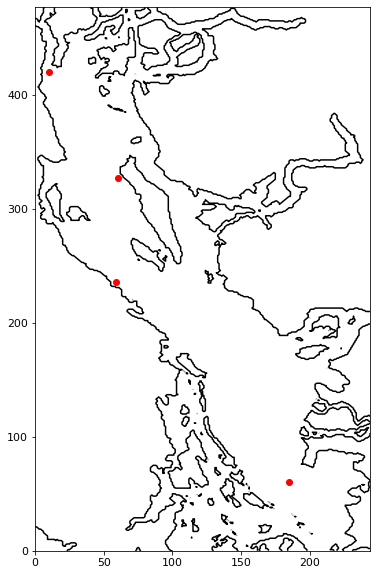

In [476]:
stations = {
    'Campbell': (730, 125),
    'Sandheads': (370, 300),
    'Parksville': (546, 174),
    'Texada': (637, 175),
}

fig, ax = plt.subplots(figsize=(6, 10))
ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
#ax.set_xlim([110, 350])
#ax.set_ylim([300, 800])
for station in stations:
    j, i = [coord - subdomains['NO3'][i] for coord, i in zip(stations[station], [2, 0])]
    ax.plot(i, j, 'ro')

In [265]:
# Load wind
masklims = [
    [(31, 45), (50, 30), (69, 8)],
    [(35, 48), (53, 31), (71, 12)],
    [(38, 48), (57, 30)],
]
imasklim = [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
window = signal.get_window('blackman', 121)
wind = np.empty(0)
for file, ilim in zip(tqdm(sorted(glob(path + 'HRDPS*'))), imasklim):
    with xr.open_dataset(file) as ds:
        
        # Meshmask
        basemask = ds.meshmask.values
        basemask[:20, :20] = 0
        for lim in masklims[ilim]:
            basemask[lim[0]:, lim[1]:] = 0
        mask = mask.reshape(-1).astype('bool')

        # Alongaxis wind
        u, v = [ds[var].values.reshape(-1, len(mask))[:, mask] for var in ['u_wind', 'v_wind']]
        jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180))

        # Process and concatenate
        wind = np.concatenate((wind, (jtau * np.sqrt(u**2 + v**2)).mean(axis=1)))

# Build time index
wind = signal.convolve((wind, window / sum(window), mode='same')
time = np.array([datetime(2010, 1, 1) + timedelta(hours=hour) for hour in range(len(wind))])

In [477]:
window = signal.get_window('blackman', 121)
nitrate = {}
for station in stations: nitrate[station] = np.empty(0)
for file in tqdm(sorted(glob(path + 'SalishSea*'))):
    with xr.open_dataset(file) as ds:
        for station in stations:
            j, i = [coord - subdomains['NO3'][i] for coord, i in zip(stations[station], [2, 0])]
            nitrate[station] = np.concatenate((nitrate[station], ds.nitrate[:, j, i].values))
for station in stations:
    nitrate[station] = signal.convolve(nitrate[station], window / sum(window), mode='same')

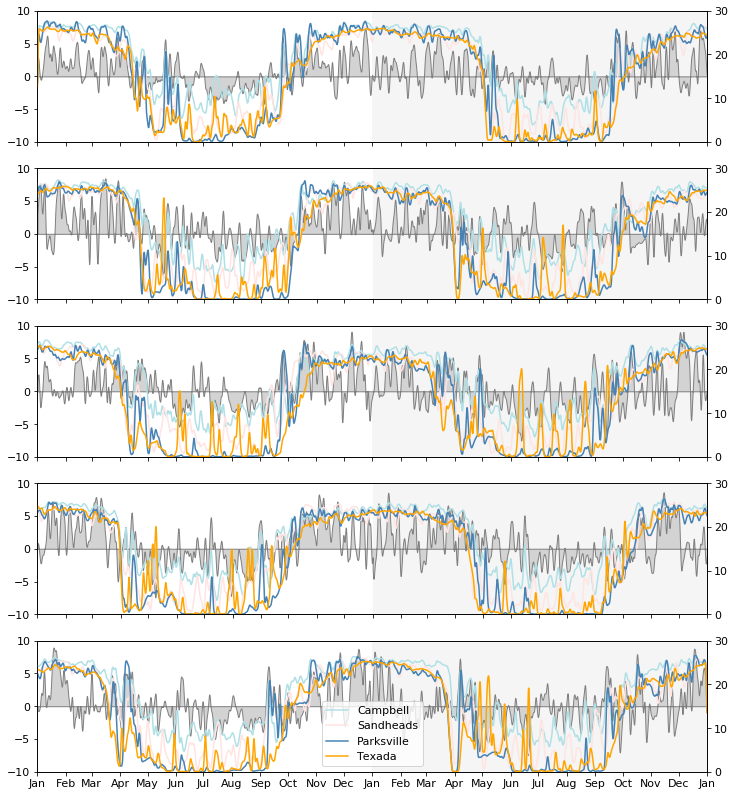

In [478]:
fig, axs = plt.subplots(6, 1, figsize=(12, 14), gridspec_kw={'hspace': 0.2})
gs = plt.GridSpec(6, 4, height_ratios=[1, 1, 1, 1, 1.2])
axs = [fig.add_subplot(gs[row, :]) for row in range(4)]
for ax, year in zip(axs, range(2010, 2020, 2)):
    index = [abs(time - datetime(year+y, 1, 1)).argmin() for y in [0, 2]]
    ax.fill_between(time[slice(*index)], wind[slice(*index)], facecolor='lightgray', edgecolor='gray')
    ax.add_patch(Rectangle((datetime(year+1, 1, 1), -10), timedelta(days=366), 20, facecolor='whitesmoke', zorder=-10))
    ax2 = ax.twinx()
    ax2.set_ylim([0, 30])
    for station, color in zip(stations, ['powderblue', 'mistyrose', 'steelblue', 'orange']):
        ax2.plot(time[slice(*index)], nitrate[station][slice(*index)], color=color, label=station)
    ax.set_xlim([datetime(year, 1, 1), datetime(year+2, 1, 1)])
    ax.set_ylim([-10, 10])
    ax.xaxis.set_major_locator(getattr(mdates, f'MonthLocator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    if year < 2018: ax.xaxis.set_ticklabels('')
ax2.legend()

In [4]:
# Load hindcast nitrate and wind along sections
window = signal.get_window('blackman', 73)
wind = signal.convolve(HRDPS.windspeed.values.mean(axis=1), window / sum(window), mode='same')
for sec, offset in zip(tqdm(sections), [77, 4, 54, 4]):
    sec['nitrate'] = {}
    yx = (sec['yx'][0]-subdomains['NO3'][2], sec['yx'][1][0]-subdomains['NO3'][0]+offset)
    sec['nitrate']['raw'] = ptrc.nitrate[(slice(None), 0) + yx].values
    sec['nitrate']['filtered'] = signal.convolve(sec['nitrate']['raw'], window / sum(window), mode='same')

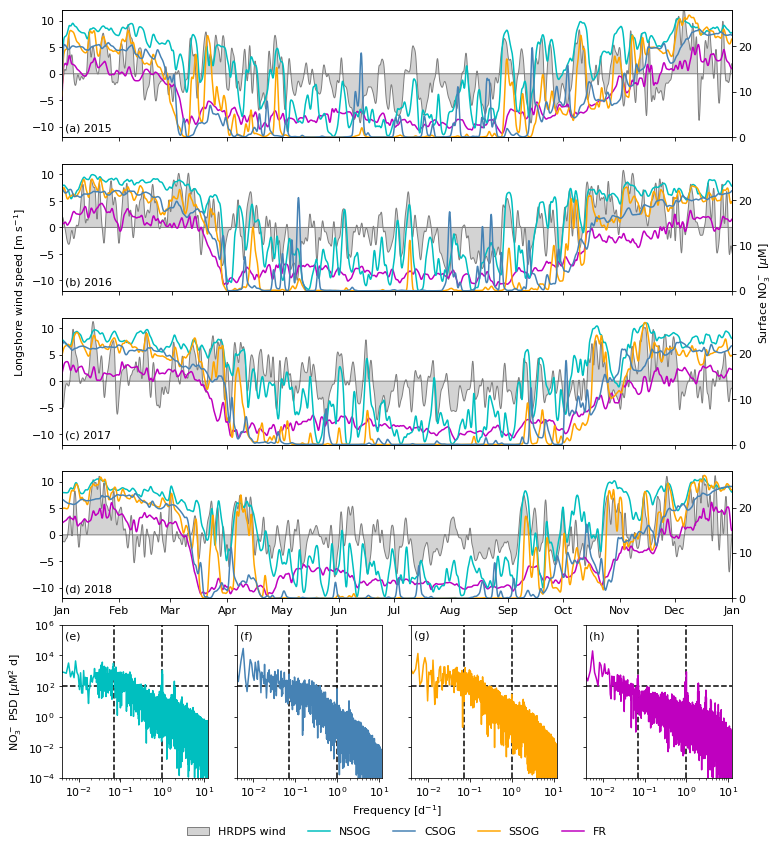

In [7]:
# Plot HRDPS and hindcast timeseries
fig = plt.figure(figsize=(12, 13))
gs = plt.GridSpec(5, 4, height_ratios=[1, 1, 1, 1, 1.2])
axs = [fig.add_subplot(gs[row, :]) for row in range(4)]
l = [0, 0, 0, 0, 0]
for ax, year in zip(axs, range(2015, 2019)):
    ax_right = ax.twinx()
    l[4] = ax.fill_between(HRDPS.time.values, wind, facecolor='lightgray', edgecolor='gray')
    for i in [0, 3, 1, 2]:
        sec = sections[i]
        l[i], = ax_right.plot(ptrc.time_counter, sec['nitrate']['filtered'], color=sec['c'], label=sec['name'])
    for axis, ylim, ylabel in zip([ax, ax_right], [[-12, 12], [-0.05, 28]], ['Longshore wind speed [m s$^{-1}$]', 'Surface NO$_3^-$ [$\mu$M]']):
        axis.set_ylim(ylim)
        if year == 2017: axis.set_ylabel(ylabel, y=1.2)
    ax.set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])
    ax.xaxis.set_major_locator(getattr(mdates, f'MonthLocator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.text(0.005, 0.05, f'({chr(year-1918)}) {year}', transform=ax.transAxes)
    if year < 2018: ax.xaxis.set_ticklabels('')

# Plot surface nitrate PSD at coastal stations
axs = [fig.add_subplot(gs[4, col]) for col in range(4)]
xlim, ylim, n = [4e-3, 12], [1e-4, 1e6], ptrc.time_counter.size
freq = np.linspace(-12, 12, n)
peaks = [1, 14]
for i, ax, sec in zip(range(4), axs, sections[::-1]):
    ax.plot(xlim, [1e2, 1e2], 'k--')
    for peak in peaks: ax.plot([1 / peak, 1 / peak], ylim, 'k--')
    PSD = abs(fftshift(fft(sec['nitrate']['raw'])))**2 / 86400
    ax.plot(freq, PSD, '-', color=sec['c'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.text(0.02, 0.91, f'({chr(101+i)})', transform=ax.transAxes)
    ax.xaxis.set_ticks([1e-2, 1e-1, 1, 10])
    if i == 0: ax.set_ylabel('NO$_3^-$ PSD [$\mu$M$^2$ d]')
    else: ax.yaxis.set_ticklabels('')
    if i == 1: ax.set_xlabel('Frequency [d$^{-1}$]', x=1.1)

fig.legend(l[::-1], ['HRDPS wind', 'NSOG', 'CSOG', 'SSOG', 'FR'], ncol=5, loc=[0.235, 0], frameon=False)
plt.subplots_adjust(bottom=0.06)
fig.savefig('/home/bmoorema/Desktop/full_hindcast.pdf', bbox_inches='tight')